For use with the Arduino code: **StirlingEngineDataTakingArduino**

# Function Declaration
This first cell of code sets up functions for us to call to make data taking easier. The fuctions take the numbers recorded from our sensors and turns them into the values we need.

In [1]:
import serial
import time
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
import pandas as pd
import math as m
import datetime

def degreeconvert(a,b):
    a = int(a)
    b = int(b)
    ba = '{:0>8}'.format(str(bin(a))[2:]) #display the strings passed as 8 bit binary
    bb = '{:0>8}'.format(str(bin(b))[2:])

    #this step was described in the SPI documentation for the Rotary Encoder
    total = ba[4:] + bb #combine the second half of the first byte with the second to get the data point

    number = int(total,2) #convert that binary number into a usable integer
    deg = (number * 360)/4096 #convert that integer into a value in degrees
    return deg

def pressureconvert(p,r):
    bp = '{:0>8}'.format(str(bin(p))[2:]) #converts the numbers passed in as 8 bit binary
    br = '{:0>8}'.format(str(bin(r))[2:])

    p1 = bp[2:] 

    ptotal = p1 + br #combine part of the first number with the second
    
    output = int(ptotal, 2) #convert the number to decimal form

    #below code converts the decimal number into a kPa pressure value
    #____________________________________________________________________#
    percent_output = (output/16384)*100 

    pressure = ((percent_output-10)*(1.6))/80
    pressurekpa = pressure*100
    #____________________________________________________________________#
    return pressurekpa

def tempconvert(o,t): #converts the hex value to a temperature reading
    bo = '{:0>8}'.format(str(bin(o))[2:])
    bt = '{:0>8}'.format(str(bin(t))[2:])
    
    z = bo + bt
    x = '0b' + z
    c = int(x,2)
    v = c>>2
    n = v*0.25
    return n


C:\Users\Garrett\AppData\Local\Temp\ipykernel_9896\96030965.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Taking
The cell below contains the code you will run to take your data. First make sure you change your file name for each data run, or you will over write your old data and cause errors in the program. Also as you are setting this up for the first time check to see which COM port your Arduino is currently connected to, and update the **PORT** variable accordingly.

Running this cell will create a prompt box where you will enter the number of data points you want to record for this run. Simply type the number and press enter. You will be prompted by the program when the data is saved. 

In [5]:
MYINITIALS = 'GAKWAF'

#Here is the filename construction based upon date and time.
ddtt = datetime.datetime.now()
nameformat="%Y%m%d_%H%M%S"
myrootfilename = MYINITIALS + ddtt.strftime(nameformat)

PORT = 'COM5' #change this to the port your arduino is connected to

tfile = "Data/" + myrootfilename + ".txt" #creates the full file name to save the raw data to
cfile = "Data/" + myrootfilename + ".csv" #creates the full file name to save the useable data to

num = ""
num = input("Enter Desired Number of Data Points: ") #prompts the user to input the number of data points to take

rawdata = []
arduino = serial.Serial(port=PORT,  baudrate=115200, timeout=.1) #connect to the Arduino
#letter = "a" #uncomment for append
letter = "w" #uncomment for write over
file = open(tfile,letter)#creates or opens a file to save the data to

i = 0
while(i < int(num)):
    #print('inside first loop',i,'\n')

    #time.sleep(0.1) #wait for the arduino to collect the data
    while True:
        arduino.write(bytes("1\n",  'utf-8'))#writes the value x as a byte to the arduino
        l = arduino.read(1) #read one byte from the Arduino
        #print('read a byte from the Arduino', l)
        if(l == b'%'): #wait until the Arduino sends a %
            data = arduino.readline() #read the data in
            break
    rawdata.append(str(data)+"\n")
    i += 1

file.writelines(rawdata) #saves the data to a .txt file
print("Data Saved as", tfile)
file.close() #close connection to the file
arduino.close() #close connection to the arduino 

KeyboardInterrupt: 

In [7]:
#usb access

arduino.close()

# Data Analysis
The cell below contains code that will call the above functions and use them to convert the data we collected to the form we need. This code will also arrange and save that data to a **.csv** file with the same name and in the same location as your raw data file, which will be a **.txt**

In [15]:
filename = "4-5-3Data"
tfile = "Data/" + filename + ".txt" #creates the full file name to save the raw data to
cfile = "Data/" + filename + ".csv" #creates the full file name to save the useable data to

# Open the file and read its content.
with open(tfile) as f:
    rawdata = f.read().splitlines()
    
f.close()

#rawdata = str(rawdata[0])

In [6]:
R = 1.2 #radius of piston movement 
l = 3.419 #length of the piston "leg"
d = 2.5 #diameter of the piston head
ma = 7.277 #maximum distance

size = len(rawdata)
a = 0
b = "0"

#create numpy arrays for the data readings from the sensor
time = np.zeros(size)
pos = np.zeros(size)
rad = np.zeros(size)
press = np.zeros(size)
t1 = np.zeros(size)
t2 = np.zeros(size)

#loops through all items in the rawdata list
for s in rawdata:
    rdata = s.split(',') #splits the line into individual numbers 
    b = rdata[0] #grabs the first number value
    
    if a == 0: #grabs the first time reading to be zeroed out later
        ztime = int(b[2:],16)
    
    degree = degreeconvert(int(rdata[1],16),int(rdata[2],16)) #gets the degree reading from the numbers
    A = degree*(m.pi/180) #changes it to radians
    rad[a] = A
    #converts it to volume
    sin2 = np.sin(A)*np.sin(A) 
    cos = np.cos(A)
    L = l ** 2
    Rr = R ** 2
    under = L-Rr*sin2
    root = m.sqrt(under)
    x = R*cos+root #all prior lines convert the angle to 'x'
    newx = ma-x
    
    pos[a] = 32+((4.619-(newx))*((m.pi/4)*d**2)) #turns the x into volume
    time[a] = int(b[2:],16)-ztime #subracts the first time from the current time to zero is
    press[a] = pressureconvert(int(rdata[3],16),int(rdata[4],16)) #converts the pressure
    t1[a] = tempconvert(int(rdata[5],16),int(rdata[6],16)) #converts temperature 1
    t2[a] = tempconvert(int(rdata[7],16),int(rdata[8],16)) #converts temperature 2
    
    a += 1
    
data = np.zeros([len(time),6])

i = 0
while i < len(time):
    data[i,0] = time[i]
    data[i,1] = rad[i]
    data[i,2] = pos[i]
    data[i,3] = press[i]
    data[i,4] = t1[i]
    data[i,5] = t2[i]
    i +=1
 

dataclean = pd.DataFrame(data, columns=['Time(ms)', 'Angle(rad)','Volume', 'Pressure(kPa)', 'Temperature 1(C)', 'Temperature 2(C)'])

dataclean.to_csv(cfile, index = False)
print("Data Saved as ", cfile)

Data Saved as  Data/EDPH20240916_110911.csv


# Graphing
The cell below will graph your data, volume versus pressure.

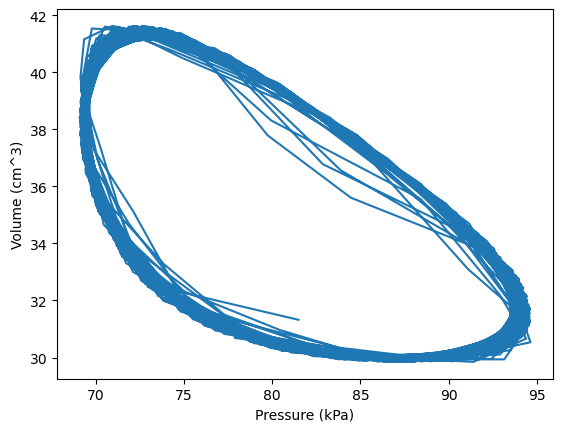

In [14]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(press,pos)  # Plot some data on the axes.
ax.set_xlabel('Pressure (kPa)')
ax.set_ylabel('Volume (cm^3)')
plt.show()